## Importing python libraries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import seed
seed(14)
from tensorflow.random import set_seed
set_seed(14)
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

#### Importing Diabetes dataset

In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
### Dataset shape
df.shape
## This tells us that we have 768 rows and 9 columns in our dataset

(768, 9)

In [5]:
### Looking at any 5 data rows in the dataset
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
274,13,106,70,0,0,34.2,0.251,52,0
352,3,61,82,28,0,34.4,0.243,46,0
603,7,150,78,29,126,35.2,0.692,54,1
484,0,145,0,0,0,44.2,0.630,31,1
137,0,93,60,25,92,28.7,0.532,22,0


In [6]:
### Checking for any missing value in the dataset
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
### Checking the percentage of the target variable for positive and negative class
df.Outcome.value_counts(dropna=False)/df.shape[0]*100

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

In [8]:
### Checking the stats for every variable
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
### Checking correlation of different variables
corr = df.drop('Outcome',1).corr()
corr.style.background_gradient(cmap ='coolwarm')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


## Scaling some feature 

In [10]:
### Columns which need standardization
cols_normalize = ['Pregnancies','BloodPressure','SkinThickness','Insulin','BMI','Age','Glucose']
### Columns left which doesn't require standardization
cols_left = list(set(df.columns) - set(cols_normalize))

In [11]:
# create a standard scaler object
std_scaler = StandardScaler()

In [12]:
### Standardizing the columns which are in variable cols_normalize
df_std = pd.DataFrame(std_scaler.fit_transform(df[cols_normalize]),columns=cols_normalize)

In [13]:
### Getting the remaining columns into the new dataset
df_std[cols_left] = df[cols_left]

In [14]:
# ### Here we are calculating the max and min value of a feature and scaling it.
# def min_max_scaling(column_name,dataframe):
#     min_value = dataframe[column_name].min()
#     max_value = dataframe[column_name].max()
#     dataframe[column_name] = dataframe[column_name].apply(lambda x: (x-min_value)/(max_value-min_value))
#     return (dataframe[column_name])

# for i in cols_normalize:
#     df[i] = min_max_scaling(i,df)

## Dividing the dataset into 3 parts

In [15]:
### Initially here we are dividing the dataset into train and test which is 60 - 40. But afterwards we are dividing test again into test and validation. Making the overall percentage as 60-20-20.
x_train,x_val,y_train,y_val = train_test_split(df_std.drop(['Outcome'],axis=1),df_std.Outcome,stratify=df.Outcome,test_size=0.4,random_state=14)
x_test,x_val,y_test,y_val = train_test_split(x_val,y_val,stratify=y_val,test_size=0.5,random_state=14)

In [16]:
print("Shape of train dataset: ",x_train.shape)
print("Shape of validation dataset: ",x_val.shape)
print("Shape of test dataset: ",x_test.shape)

Shape of train dataset:  (460, 8)
Shape of validation dataset:  (154, 8)
Shape of test dataset:  (154, 8)


# Logistic Regression

In [17]:
### Defining a sigmoid function
def sigmoid_function(z):
    sig = 1/(1+np.exp(-z))
    return (sig)

### Defining cost function for logisitic
def cost_function_calculator(X,Y,prob):
    target_0 = np.multiply((1-Y),np.log(1-prob))
    target_1 = np.multiply(Y,np.log(prob))
    total_cost = -np.sum(target_0 + target_1)/X.shape[1]
    return (total_cost)

### Weights and bias update function based on the error
def parameter_update(X,Y,weight,bias,learning_rate,prob):
    dz = prob - Y
    dw = (np.dot(X, dz.T))/X.shape[1] 
    db = (np.sum(dz))/X.shape[1]
    weight = weight - learning_rate * dw #updating the weight vector
    bias = bias - learning_rate * db #updating the bias vector
    return (weight,bias)

### Function to predict the target based on new feature values.
def predict_logistic(x,weight,bias,threshold=0.5):
    z = np.dot(weight.T,x) + bias
    prob = sigmoid_function(z)
    fixed_val = np.where(prob>threshold,1,0)
    return(prob,fixed_val)

### function to train logistic regression
## In the below function epoch and learning_rate are the hyperparameters
def train_logistic_regression(X,Y,val_x,val_y,epoch=1000,learning_rate=0.05,seed=140,threshold=0.5):
    ### Inserting all the features column into an array
    X = np.array(x_train)
    Y = np.array(y_train)
    X = X.T
    Y =  Y.reshape(1, Y.shape[0]) 
    ### Above steps being done for validation set
    if len(val_x)!=0:
      X_val = np.array(val_x)
      Y_val = np.array(val_y)
      X_val = X_val.T
      Y_val =  Y_val.reshape(1, Y_val.shape[0]) 
      loss_val = []
      acc_val = []
    ### Setting a random seed value to have the same result again and again
    np.random.seed(seed)
    ### Defining weight variable and bias variable and initializing with random number
    weight = np.random.rand(X.shape[0]).reshape((X.shape[0],1)) ## We took X.shape[0] because that signifies how many independent variable exist in the dataset which is equal to the number of weights as each independent feature has a weight assigned to it 
    bias = np.random.rand()
    loss = []
    acc_train = []
    for i in range(0,epoch):
        ### Multiplying weights with feature value and adding bias.
        z = np.dot(weight.T,X) + bias
        ### Using the sigmoid function determining the value of output variable
        prob = sigmoid_function(z)
        ### Calculaing error from the actual value as well as returning the model prediction at threshold 0.5
        cost_function = cost_function_calculator(X,Y,prob)
        loss.append(np.squeeze(cost_function))
        ### Calculating train accuracy at the moment at 0.5 threshold, can we set accordingly
        train_targets = np.where(prob>threshold,1,0)
        acc_train.append((((train_targets==Y).sum())/Y.shape[1]))
        try:
          prob_val, validation_targets = predict_logistic(X_val,weight,bias,threshold)
          cost_function_val = cost_function_calculator(X_val,Y_val,prob_val)
          loss_val.append(np.squeeze(cost_function_val))
          acc_val.append((((validation_targets==Y_val).sum())/Y_val.shape[1]))
        except:
          pass
        ### Based on the error from original value in the previous step, updating weights accordingly
        weight,bias = parameter_update(X,Y,weight,bias,learning_rate,prob)
    if loss_val:
      return (weight,bias,loss,loss_val,[acc_train,acc_val])
    else:
      return (weight,bias,loss,acc_train)


In [18]:
### Training logistic regression and obtaining weights, bias and loss value from it
w,b,loss,loss_val,acc_scores = train_logistic_regression(x_train,y_train,val_x=x_val,val_y=y_val)

In [19]:
Y_val = np.array(y_val)
Y_val = Y_val.reshape(1, Y_val.shape[0])

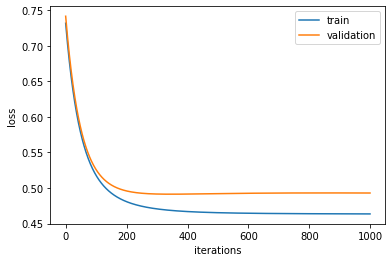

In [20]:
### Plotting the decrease in loss value on training for logistic regression
plt.plot(loss,label='train')
plt.plot(loss_val,label='validation')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()

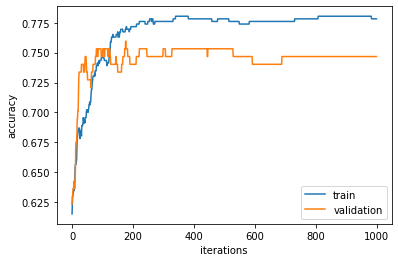

In [21]:
### Plotting the accuracy value on training and validation for logistic regression
plt.plot(acc_scores[0],label='train')
plt.plot(acc_scores[1],label='validation')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.legend()

In [22]:
### Choosing a threshold value bases on which we will say that set a cutoff that once the model predict any value over it we will say that it is a case of diabetes
threshold = 0.55

### Train classification report
print("Train classification report: \n",classification_report(y_train.values,predict_logistic(x_train.values.T,w,b,threshold)[1][0]))
### Reaching an accuracy of 78%


### Validation classification report
print("Validation classification report: \n",classification_report(y_val.values,predict_logistic(x_val.values.T,w,b,threshold)[1][0]))
### Reaching an accuracy of 77%

Train classification report: 
               precision    recall  f1-score   support

           0       0.79      0.91      0.84       299
           1       0.76      0.54      0.63       161

    accuracy                           0.78       460
   macro avg       0.77      0.72      0.74       460
weighted avg       0.78      0.78      0.77       460

Validation classification report: 
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       100
           1       0.71      0.56      0.63        54

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154



In [23]:
### Training logistic regression again with learning_rate = 0.01
w1,b1,loss1,loss1_val,acc_scores1 = train_logistic_regression(x_train,y_train,val_x=x_val,val_y=y_val,learning_rate=0.01,epoch=1000)

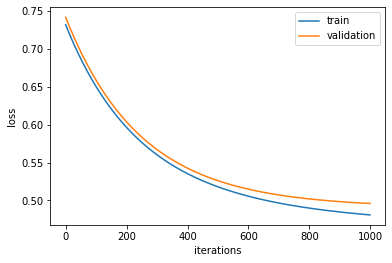

In [24]:
### Plotting the decrease in loss value on training for logistic regression
plt.plot(loss1,label='train')
plt.plot(loss1_val,label='validation')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
### From the graph we can see that the loss value when learning_rate was 0.05 was lesser than when the learning_rate is 0.01, also the loss curve hasn't saturated meaning we can increase the epoch for the model to learn more
### Hence moving forward with 0.05 learning_rate and making predictions accordingly

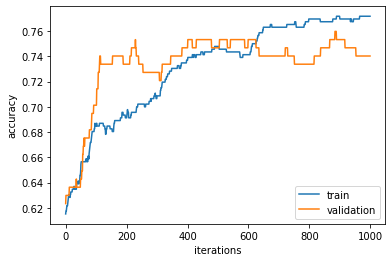

In [25]:
### Plotting the accuracy value on training and validation for logistic regression
plt.plot(acc_scores1[0],label='train')
plt.plot(acc_scores1[1],label='validation')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.legend()

In [26]:
### Choosing a threshold value bases on which we will say that set a cutoff that once the model predict any value over it we will say that it is a case of diabetes
threshold = 0.55

### Train classification report
print("Train classification report: \n",classification_report(y_train.values,predict_logistic(x_train.values.T,w1,b1,threshold)[1][0]))
### Reaching an accuracy of 78%


### Validation classification report
print("Validation classification report: \n",classification_report(y_val.values,predict_logistic(x_val.values.T,w1,b1,threshold)[1][0]))
### Reaching an accuracy of 76%

Train classification report: 
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       299
           1       0.74      0.55      0.63       161

    accuracy                           0.78       460
   macro avg       0.76      0.72      0.74       460
weighted avg       0.77      0.78      0.77       460

Validation classification report: 
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       100
           1       0.71      0.54      0.61        54

    accuracy                           0.76       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.76      0.75       154



In [27]:
### Moving forward with the previous model and predicting on test dataset

### Test classification report
print("Test classification report: \n",classification_report(y_test.values,predict_logistic(x_test.values.T,w,b,threshold)[1][0]))
### Reaching an accuracy of 79%

Test classification report: 
               precision    recall  f1-score   support

           0       0.77      0.95      0.85       101
           1       0.83      0.47      0.60        53

    accuracy                           0.79       154
   macro avg       0.80      0.71      0.73       154
weighted avg       0.79      0.79      0.77       154



# Neural Networks

## First Model iteration

In [28]:
### Defining the neural network structure
### Here we are building a one hidden layer neural network with 32 neurons
model = Sequential()
model.add(Dense(32, input_dim=8, kernel_initializer= 'normal',  activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
### Defining the model parameters such as type of optimizer, metrics we want to maximize on and the type of loss
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
### Running the model for a total of 1000 epochs
history = model.fit(x_train, y_train, epochs=1000, batch_size=64,verbose=0, validation_data=(x_val,y_val))

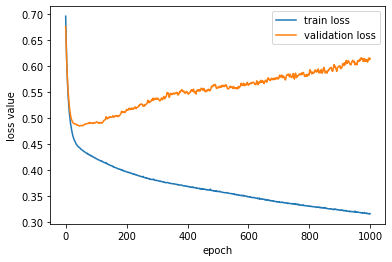

In [31]:
### Plotting train and validation loss curve
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()

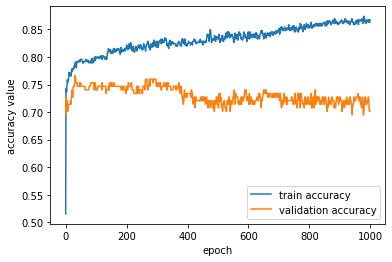

In [32]:
### Plotting train and validation loss curve
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.legend()

In [33]:
### Train classification report
print("Train classification report: \n", classification_report(y_train, np.where(model.predict(x_train)>0.55,1,0)))
### Accuracy on train set is 86%

Train classification report: 
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       299
           1       0.88      0.70      0.78       161

    accuracy                           0.86       460
   macro avg       0.87      0.82      0.84       460
weighted avg       0.86      0.86      0.86       460



In [34]:
### Validation classification report
print("Validation classification report: \n", classification_report(y_val, np.where(model.predict(x_val)>0.55,1,0)))
### Accuracy on validation set is 68%
### From the above we can see that there is a large difference in training and validation accuracy

Validation classification report: 
               precision    recall  f1-score   support

           0       0.74      0.79      0.76       100
           1       0.55      0.48      0.51        54

    accuracy                           0.68       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.67      0.68      0.68       154



## Second  model iteration

In [35]:
### Defining early stopping which will automatically stop the iteration if there is no decrease in validation loss value for 5 iteration
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [36]:
### Defining a new model in which keeping callback as earlystopping
model_1 = Sequential()
model_1.add(Dense(16, input_dim=8, kernel_initializer= 'normal', activation='relu'))
model_1.add(Dense(8, kernel_initializer= 'normal', activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

In [37]:
### Defining the model parameters such as type of optimizer, metrics we want to maximize on and the type of loss
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
### Running the model for a total of 10000 epochs
history_1 = model_1.fit(x_train, y_train, epochs=10000, batch_size=64, validation_data=(x_val,y_val), verbose=0, callbacks=es)

Epoch 00059: early stopping


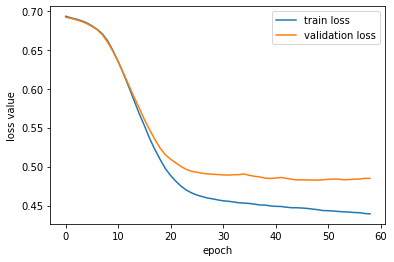

In [39]:
### Plotting train and validation loss curve
plt.plot(history_1.history['loss'],label='train loss')
plt.plot(history_1.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()

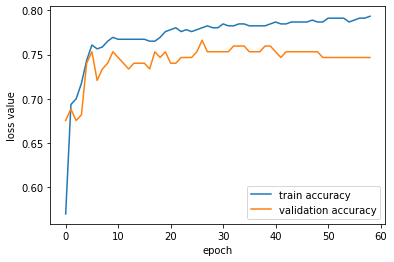

In [40]:
### Plotting train and validation accuracy curve
plt.plot(history_1.history['accuracy'],label='train accuracy')
plt.plot(history_1.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()

In [41]:
### Train classification report
print("Train classification report: \n", classification_report(y_train, np.where(model_1.predict(x_train)>0.55,1,0)))
### Train accuracy is 80%

Train classification report: 
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       299
           1       0.77      0.60      0.67       161

    accuracy                           0.80       460
   macro avg       0.79      0.75      0.76       460
weighted avg       0.79      0.80      0.79       460



In [42]:
### Validation classification report
print("Validation classification report: \n", classification_report(y_val, np.where(model_1.predict(x_val)>0.55,1,0)))
### Validation accuracy is 75%

Validation classification report: 
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.67      0.57      0.62        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154



## Third model which includes dropout

In [43]:
### Defining a new model with dropout 
model_3 = Sequential()
model_3.add(Dense(16, input_dim=8, kernel_initializer= 'normal', activation='relu'))
model_3.add(Dense(8, kernel_initializer= 'normal', activation='relu'))
model_3.add(tf.keras.layers.Dropout(0.3))
model_3.add(Dense(1, activation='sigmoid'))

In [44]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [45]:
### Defining the model parameters such as type of optimizer, metrics we want to maximize on and the type of loss
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
### Running the model for a total of 10000 epochs
history_3 = model_3.fit(x_train, y_train, epochs=10000, batch_size=64, validation_data=(x_val,y_val), verbose=0, callbacks=es)

Epoch 00059: early stopping


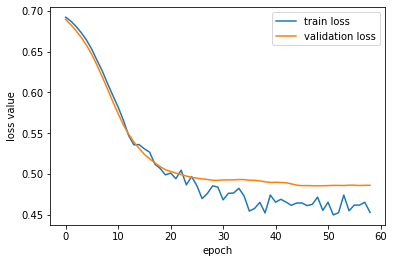

In [47]:
### Plotting train and validation loss curve
plt.plot(history_3.history['loss'],label='train loss')
plt.plot(history_3.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()

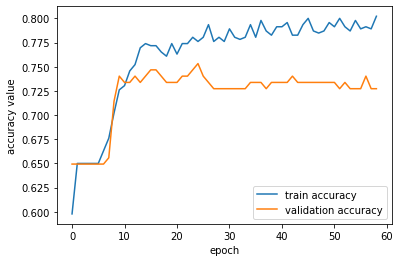

In [48]:
### Plotting train and validation loss curve
plt.plot(history_3.history['accuracy'],label='train accuracy')
plt.plot(history_3.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.legend()

In [49]:
### Train classification report
print("Train classification report: \n", classification_report(y_train, np.where(model_3.predict(x_train)>0.55,1,0)))
### Train accuracy is 80%

Train classification report: 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       299
           1       0.75      0.66      0.70       161

    accuracy                           0.80       460
   macro avg       0.79      0.77      0.78       460
weighted avg       0.80      0.80      0.80       460



In [50]:
### Validation classification report
print("Validation classification report: \n", classification_report(y_val, np.where(model_3.predict(x_val)>0.55,1,0)))
### Validation accuracy is 75%

Validation classification report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       100
           1       0.67      0.59      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



## Fourth model which will include l1 regularization

In [51]:
### Defining a new model with l1 regularization parameter
model_4 = Sequential()
model_4.add(Dense(16, input_dim=8, kernel_initializer= 'normal', activation='relu'))
model_4.add(Dense(8, kernel_initializer= 'normal', activation='relu',kernel_regularizer=tf.keras.regularizers.l1()))
model_4.add(Dense(1, activation='sigmoid'))

In [52]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [53]:
### Defining the model parameters such as type of optimizer, metrics we want to maximize on and the type of loss
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
### Running the model for a total of 10000 epochs
history_4 = model_4.fit(x_train, y_train, epochs=10000, batch_size=64, validation_data=(x_val,y_val), verbose=0, callbacks=es)

Epoch 00135: early stopping


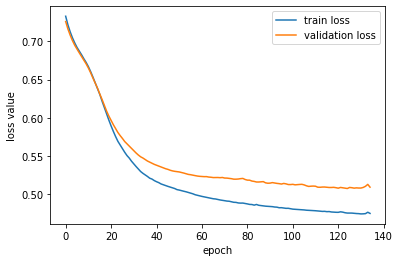

In [55]:
### Plotting train and validation loss curve
plt.plot(history_4.history['loss'],label='train loss')
plt.plot(history_4.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()

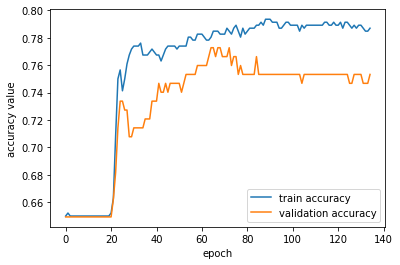

In [56]:
### Plotting train and validation accuracy curve
plt.plot(history_4.history['accuracy'],label='train accuracy')
plt.plot(history_4.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.legend()

In [57]:
### Train classification report
print("Train classification report: \n", classification_report(y_train, np.where(model_4.predict(x_train)>0.55,1,0)))
### Train accuracy is 79%

Train classification report: 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       299
           1       0.75      0.61      0.67       161

    accuracy                           0.79       460
   macro avg       0.78      0.75      0.76       460
weighted avg       0.79      0.79      0.79       460



In [58]:
### Validation classification report
print("Validation classification report: \n", classification_report(y_val, np.where(model_4.predict(x_val)>0.55,1,0)))
### Validation accuracy is 75%

Validation classification report: 
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.67      0.57      0.62        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154



### Fifth model with l2 regularization

In [59]:
### Defining a new model with l2 regularization parameter
model_5 = Sequential()
model_5.add(Dense(16, input_dim=8, kernel_initializer= 'normal', activation='relu'))
model_5.add(Dense(8, kernel_initializer= 'normal', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.2)))
model_5.add(Dense(1, activation='sigmoid'))

In [60]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [61]:
### Defining the model parameters such as type of optimizer, metrics we want to maximize on and the type of loss
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
### Running the model for a total of 10000 epochs
history_5 = model_5.fit(x_train, y_train, epochs=10000, batch_size=64, validation_data=(x_val,y_val), verbose=0, callbacks=es)

Epoch 00131: early stopping


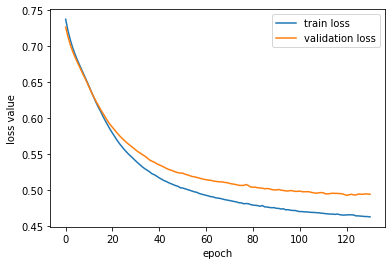

In [63]:
### Plotting train and validation loss curve
plt.plot(history_5.history['loss'],label='train loss')
plt.plot(history_5.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()

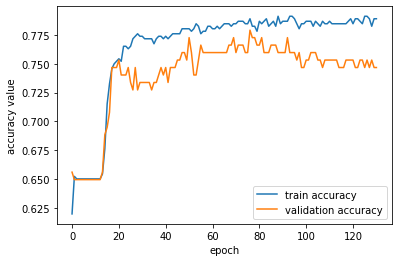

In [64]:
### Plotting train and validation accuracy curve
plt.plot(history_5.history['accuracy'],label='train accuracy')
plt.plot(history_5.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.legend()

In [65]:
### Train classification report
print("Train classification report: \n", classification_report(y_train, np.where(model_5.predict(x_train)>0.55,1,0)))
### Train accuracy is 79%

Train classification report: 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       299
           1       0.75      0.61      0.67       161

    accuracy                           0.79       460
   macro avg       0.78      0.75      0.76       460
weighted avg       0.79      0.79      0.79       460



In [66]:
### Validation classification report
print("Validation classification report: \n", classification_report(y_val, np.where(model_5.predict(x_val)>0.55,1,0)))
### Validation accuracy is 76%

Validation classification report: 
               precision    recall  f1-score   support

           0       0.79      0.86      0.82       100
           1       0.69      0.57      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



In [67]:
### Test classification report
### Using the model in which l2 norm was applied as it has the best metrics on both train and validation test
print("Test classification report: \n", classification_report(y_test, np.where(model_5.predict(x_test)>0.55,1,0)))
### Test set validation accuracy is 77%

Test classification report: 
               precision    recall  f1-score   support

           0       0.77      0.91      0.84       101
           1       0.74      0.49      0.59        53

    accuracy                           0.77       154
   macro avg       0.76      0.70      0.71       154
weighted avg       0.76      0.77      0.75       154

